In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('US100.csv', sep=',', usecols=['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME'])
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

df

,OPEN,HIGH,LOW,CLOSE,VOLUME
DATE,,,,,
2020-03-03,8838.50,9000.75,8540.64,8559.12,640841
2020-03-04,8547.80,8949.85,8511.88,8889.48,534261
2020-03-05,8885.85,8899.10,8612.16,8674.98,363011
2020-03-06,8672.30,8726.60,8314.22,8505.60,658061
2020-03-09,8173.85,8243.98,7823.60,7920.48,587381
...,...,...,...,...,...
2025-02-24,21649.85,21746.65,21341.54,21356.24,219979
2025-02-25,21372.15,21387.85,20927.65,21127.34,245678
2025-02-26,21172.85,21347.43,21003.73,21157.74,214753


In [85]:
dia_de_alta = df['CLOSE'] > df['OPEN']
dia_de_baixa = df['CLOSE'] < df['OPEN']
dia_even = df['CLOSE'] == df['OPEN']

In [86]:
#periodo = int(input('Diga qual o período de teste (2020-2025): '))

df['up/down/even day'] = 'even'
df.loc[df['CLOSE'] > df['OPEN'], 'up/down/even day'] = 'up'
df.loc[df['CLOSE'] < df['OPEN'], 'up/down/even day'] = 'down'
#df = df[df.index.year == periodo]
df.head()

,OPEN,HIGH,LOW,CLOSE,VOLUME,up/down/even day
DATE,,,,,,
2020-03-03,8838.50,9000.75,8540.64,8559.12,640841,down
2020-03-04,8547.80,8949.85,8511.88,8889.48,534261,up
2020-03-05,8885.85,8899.10,8612.16,8674.98,363011,down
2020-03-06,8672.30,8726.60,8314.22,8505.60,658061,down
2020-03-09,8173.85,8243.98,7823.60,7920.48,587381,down


In [87]:
df['up/down/even day'].value_counts()
#aproximadamente 54% dos dias foram dias de alta

up/down/even day
up      710
down    582
Name: count, dtype: int64

In [88]:
df['prev_day'] = df['up/down/even day'].shift(1)

def get_side(prev):
    if prev == 'down':
        return 'long'
    elif prev == 'up':
        return 'short'
    return None

df['side'] = df['prev_day'].apply(get_side)

In [ ]:
def calc_pnl(row):
    if row['side'] == 'long':
        return row['CLOSE'] - row['OPEN']
    elif row['side'] == 'short':
        return row['OPEN'] - row['CLOSE']
    return 0.0

df['pnl_pts'] = df.apply(calc_pnl, axis=1)

trades = df[df['side'].notna()].copy()
trades['equity'] = trades['pnl_pts'].cumsum()

Gráfico salvo em: backtest_reversao.png


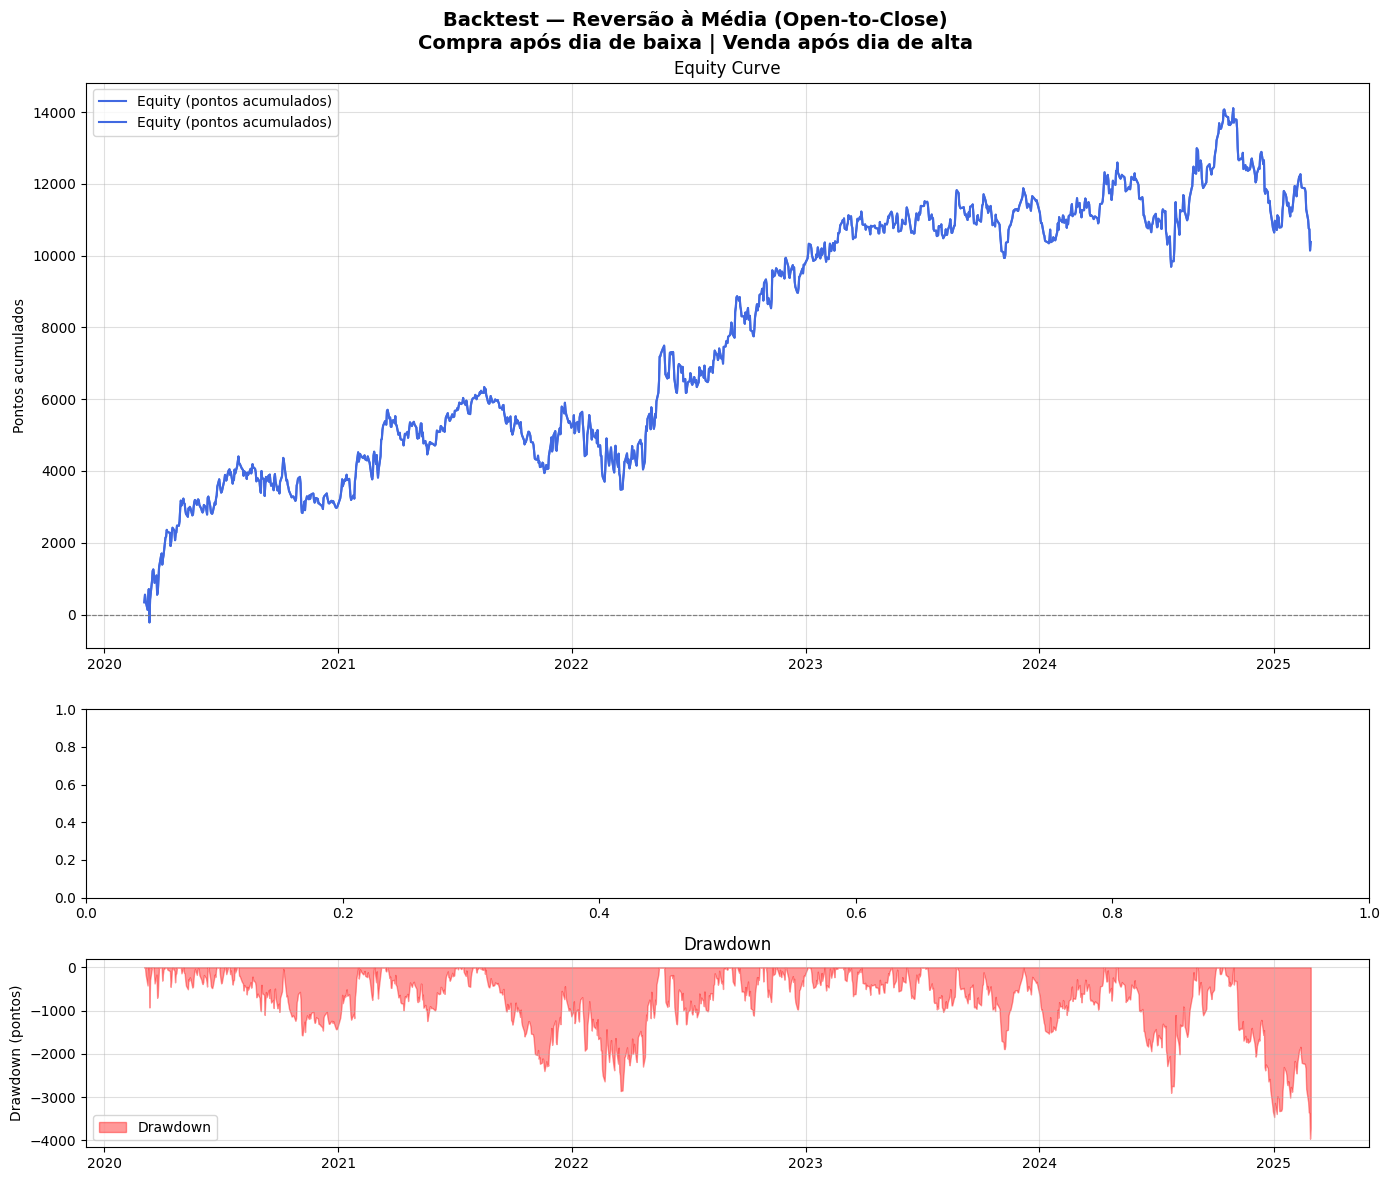

In [90]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12),
                         gridspec_kw={'height_ratios': [3, 1, 1]})
fig.suptitle(
    'Backtest — Reversão à Média (Open-to-Close)\n'
    'Compra após dia de baixa | Venda após dia de alta',
    fontsize=14, fontweight='bold'
)

axes[0].plot(trades.index, trades['equity'],
             color='royalblue', linewidth=1.5, label='Equity (pontos acumulados)')
axes[0].axhline(0, color='gray', linestyle='--', linewidth=0.8)
axes[0].set_ylabel('Pontos acumulados')
axes[0].set_title('Equity Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.4)

axes[0].plot(trades.index, trades['equity'],
             color='royalblue', linewidth=1.5, label='Equity (pontos acumulados)')
axes[0].axhline(0, color='gray', linestyle='--', linewidth=0.8)
axes[0].set_ylabel('Pontos acumulados')
axes[0].set_title('Equity Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.4)

rolling_max = trades['equity'].cummax()
drawdown = trades['equity'] - rolling_max
axes[2].fill_between(trades.index, drawdown, 0, color='red', alpha=0.4, label='Drawdown')
axes[2].set_ylabel('Drawdown (pontos)')
axes[2].set_title('Drawdown')
axes[2].legend()
axes[2].grid(True, alpha=0.4)

plt.tight_layout()
plt.savefig('backtest_reversao.png', dpi=150, bbox_inches='tight')
print("Gráfico salvo em: backtest_reversao.png")

In [91]:
long_trades  = trades[trades['side'] == 'long']
short_trades = trades[trades['side'] == 'short']

def stats_bloco(subset, nome):
    n       = len(subset)
    wins    = (subset['pnl_pts'] > 0).sum()
    losses  = (subset['pnl_pts'] < 0).sum()
    total   = subset['pnl_pts'].sum()
    media   = subset['pnl_pts'].mean()
    win_avg = subset.loc[subset['pnl_pts'] > 0, 'pnl_pts'].mean() if wins else 0
    los_avg = subset.loc[subset['pnl_pts'] < 0, 'pnl_pts'].mean() if losses else 0
    wr      = wins / n * 100 if n else 0
    payoff  = abs(win_avg / los_avg) if los_avg else float('inf')

    print(f'  {nome}')
    print(f'  Nº de operações  : {n}')
    print(f'  Ganhos / Perdas  : {wins} / {losses}')
    print(f'  Win Rate         : {wr:.1f}%')
    print(f'  Resultado total  : {total:+.2f} pts')
    print(f'  Média / operação : {media:+.2f} pts')
    print(f'  Média dos ganhos : {win_avg:+.2f} pts')
    print(f'  Média das perdas : {los_avg:+.2f} pts')
    print(f'  Payoff ratio     : {payoff:.2f}')

print('RESUMO DO BACKTEST')
print(f'Período  : {trades.index[0].date()} → {trades.index[-1].date()}')
print(f'Operações: {len(trades)}')
print(f'{"═"*50}')
stats_bloco(long_trades,  "LONG  (compra após dia de baixa)")
stats_bloco(short_trades, "SHORT (venda após dia de alta)")
stats_bloco(trades,       "COMBINADO (todas as operações)")
print(f'{"═"*50}\n')
print('Gráfico salvo em: backtest_reversao.png')

RESUMO DO BACKTEST
Período  : 2020-03-04 → 2025-02-28
Operações: 1291
══════════════════════════════════════════════════
  LONG  (compra após dia de baixa)
  Nº de operações  : 582
  Ganhos / Perdas  : 326 / 256
  Win Rate         : 56.0%
  Resultado total  : +11199.31 pts
  Média / operação : +19.24 pts
  Média dos ganhos : +162.83 pts
  Média das perdas : -163.60 pts
  Payoff ratio     : 1.00
  SHORT (venda após dia de alta)
  Nº de operações  : 709
  Ganhos / Perdas  : 325 / 384
  Win Rate         : 45.8%
  Resultado total  : -817.23 pts
  Média / operação : -1.15 pts
  Média dos ganhos : +151.89 pts
  Média das perdas : -130.68 pts
  Payoff ratio     : 1.16
  COMBINADO (todas as operações)
  Nº de operações  : 1291
  Ganhos / Perdas  : 651 / 640
  Win Rate         : 50.4%
  Resultado total  : +10382.08 pts
  Média / operação : +8.04 pts
  Média dos ganhos : +157.36 pts
  Média das perdas : -143.85 pts
  Payoff ratio     : 1.09
══════════════════════════════════════════════════

Grá